In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# initialize the parameters using a normal distribution
# also reduce the size of the weights to prevent tanh saturation and dead neurons
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # """ Kaiming initialization using a tanh nonlinearity """
# b1 = torch.randn(n_hidden,                        generator=g)  * 0.01 - don't add bias here because the batch normalisation is doing the biasing now
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
"bias and gain allow the batchnorm gaussian to mvoe around and scale rather than be continuiously forced to be sd 1 and mean 0 for every neuron "
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden)) # track the running mean of the batch which is initialised as 0
bnstd_running = torch.ones((1, n_hidden)) # track the running std of the batch which is initialised as 1

parameters = [C, W1, W2, b2] #, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [8]:
"""
You can actually use batch normalsiation 

max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):

    # Construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g) # construct random tensor of indices
    Xb, Yb = Xtr[ix], Ytr[ix] # construct minibatch by reandomly selecting indices from training data

    # forward pass
    emb = C[Xb] # embed the minibatch characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors - The first argument emb.shape[0] specifies that the first dimension of the reshaped tensor should remain the same as the original tensor emb. The second argument -1 means that the size of the second dimension should be automatically inferred based on the size of the original tensor and the specified first dimension. Specifically, -1 tells PyTorch to infer the size of the second dimension such that the total number of elements in the reshaped tensor remains the same as the original tensor.
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # compute the loss

    # backward pass - this literally passes backwards through the above code from loss to emb
    for p in parameters:
        p.grad = None
    loss.backward() # compute the gradients

    # update 
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print stats every 10000 steps
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())

    break

"""

"\nYou can actually use batch normalsiation \n\nmax_steps = 20000\nbatch_size = 32\nlossi = []\n\nfor i in range(max_steps):\n\n    # Construct minibatch\n    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g) # construct random tensor of indices\n    Xb, Yb = Xtr[ix], Ytr[ix] # construct minibatch by reandomly selecting indices from training data\n\n    # forward pass\n    emb = C[Xb] # embed the minibatch characters into vectors\n    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors - The first argument emb.shape[0] specifies that the first dimension of the reshaped tensor should remain the same as the original tensor emb. The second argument -1 means that the size of the second dimension should be automatically inferred based on the size of the original tensor and the specified first dimension. Specifically, -1 tells PyTorch to infer the size of the second dimension such that the total number of elements in the reshaped tensor remains the same as the origi

In [9]:
"""Using batch normalisation"""

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # Construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g) # construct random tensor of indices
    Xb, Yb = Xtr[ix], Ytr[ix] # construct minibatch by reandomly selecting indices from training data

    # forward pass
    emb = C[Xb] # embed the minibatch characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors - The first argument emb.shape[0] specifies that the first dimension of the reshaped tensor should remain the same as the original tensor emb. The second argument -1 means that the size of the second dimension should be automatically inferred based on the size of the original tensor and the specified first dimension. Specifically, -1 tells PyTorch to infer the size of the second dimension such that the total number of elements in the reshaped tensor remains the same as the original tensor.
    "want to make hpreact roughly gaussian"
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation - don't add bias here because the batch normalisation is doing the biasing now
    """batch normalisation using gain and shift """
    bnmeani= hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain*(hpreact - bnmeani) / bnstdi + bnbias

    " calculate the running mean and std of the batch so that you don't need to do it separately as in a few blocks below"
    with torch.no_grad(): # don't compute gradients for the running mean and std
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # compute the loss

    # backward pass - this literally passes backwards through the above code from loss to emb
    for p in parameters:
        p.grad = None
    loss.backward() # compute the gradients

    # update 
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print stats every 10000 steps
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())

print('Final achieved loss:', lossi[-1].log10())


      0/ 200000: 3.323863
  10000/ 200000: 2.042951
  20000/ 200000: 2.530759
  30000/ 200000: 2.041835
  40000/ 200000: 2.292791
  50000/ 200000: 1.843099
  60000/ 200000: 2.053564
  70000/ 200000: 2.245976
  80000/ 200000: 2.361888
  90000/ 200000: 2.048406
 100000/ 200000: 2.303238
 110000/ 200000: 2.324622
 120000/ 200000: 1.646764
 130000/ 200000: 1.999532
 140000/ 200000: 2.289608
 150000/ 200000: 2.011173
 160000/ 200000: 2.091702
 170000/ 200000: 2.473447
 180000/ 200000: 2.071307
 190000/ 200000: 2.086669


AttributeError: 'float' object has no attribute 'log10'

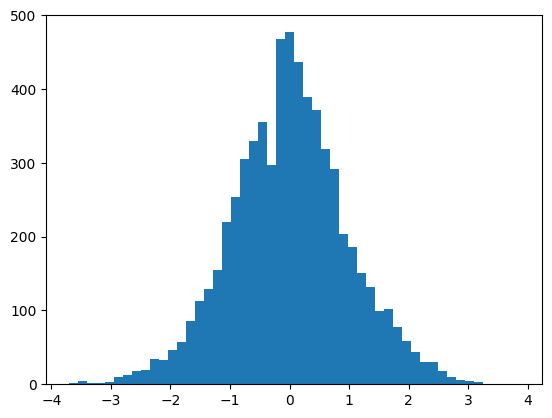

In [ ]:
# checking the preactivation values that are fed into the hdden layer.
# they will be fed to tanh activation function and so should aim for domain to be between about -1 and 1 so that the tanh function is not saturated (i.e. range not have lots of 1 or -1 values)
plt.hist(hpreact.view(-1).tolist(), 50);

# to improve you should reduce the weights and biases !!!

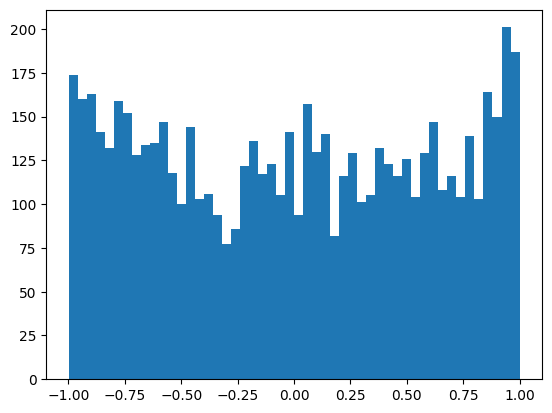

In [ ]:
# checking activation function 
plt.hist(h.view(-1).tolist(), 50);
# can see many values are -1 or 1, which will produce issues in our backpropagation algorithm

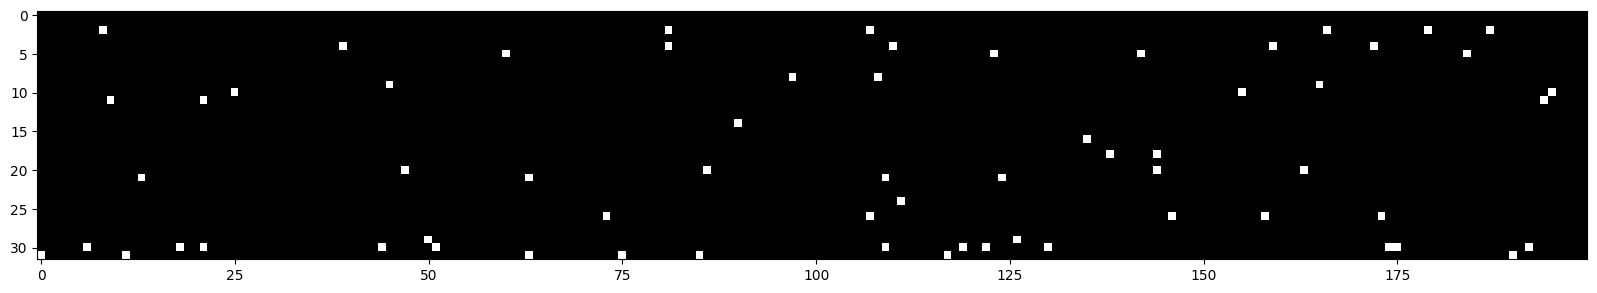

In [ ]:
# check which neurons are saturated
# saturation is problem becuase it won't learn (back prop is 0)
plt.figure(figsize=(20,10))    
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # this takes the h array and produces a boolean tensor if h value > 0.99, white if true, black if false

In [ ]:
" Calibrate the batch normalisatino after training. i.e. fixing the mean and std before validating and testing"
# In reality you dont do this - YOU DO THIS DURING TRAINING AND PRINT THE MINAL MEAN
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean and std over thr whole batch that was used to train
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() # this is a decorator that tells PyTorch not to track gradients within this block
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 
    #hpreact = bngain*(hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, 'loss:', loss.item())

split_loss('train')
split_loss('test')

train loss: 2.212538480758667
test loss: 2.2569808959960938


tensor(-0.0105) tensor(1.0030)
tensor(0.0106) tensor(3.2301)


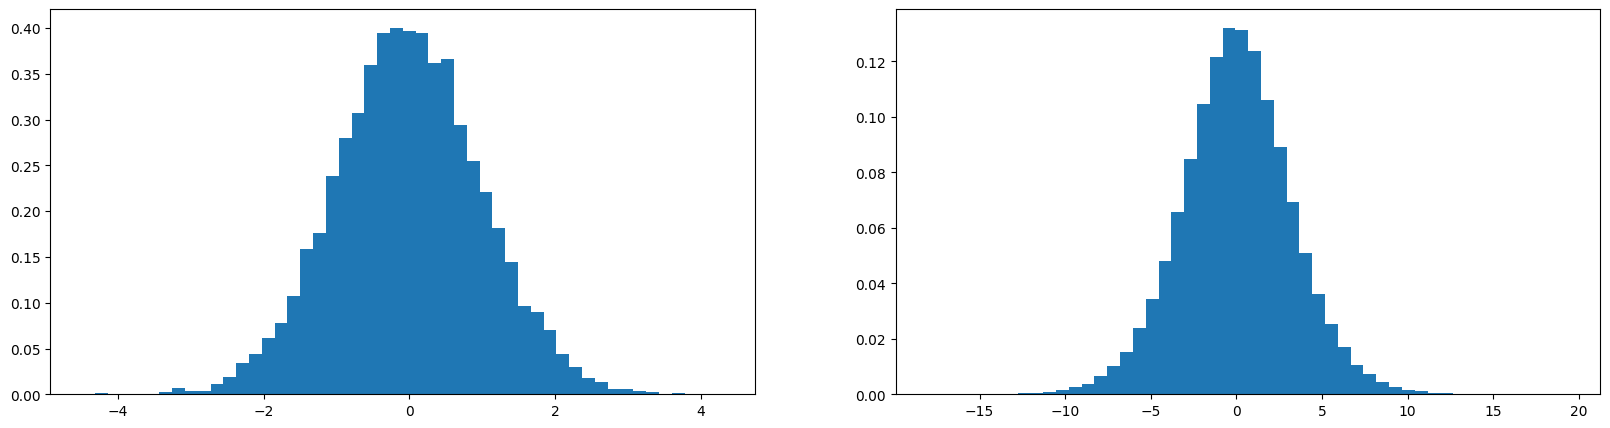

In [ ]:
# FIguring out what weights to use for the initial parameters (i.e. how to scale them down to minimise saturation)
x = torch.randn(1000,10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std()) # want output to have same mean and std as input roughly speaking
# so scale the weights by 1/sqrt(n) where n is the number of inputs to the neuron (e.g. by 1/sqrt(10) in this case)
"""
In reality you use a kaiming normal initialisation which is a bit more complicated but this is the basic idea"""

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [ ]:

def name_maker(block_size):
     
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh((emb.view(1, -1) @ W1))
        logits = h @ W2 + b2
        p = F.softmax(logits, 1)
        ix = torch.multinomial(p, 1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0: # end of name
            break
        
    return ''.join(itos[i] for i in out[:-1])

for i in range(20):
    print(name_maker(block_size))

vebh
kymm
franns
shrishmdiles
sun
jakoh
kevann
kembldis
damilseyvian
shrisabruncchostianna
maxn
rsu
kassk
jakekmny
grac
menyx
veby
shihnn
kamritzlee
shellh
